In [11]:
import numpy as np
import pandas as pd
pd.set_option("precision", 3)
import matplotlib.pyplot as plt
from funcs.fitting import loss_single_seg_fixed_T
from datetime import datetime
from funcs.models import model_ND
from scipy.optimize import minimize

The equation governing heat flow in the network is given by:

$$ C_{i} \frac{\mathrm{d} T_{i}}{\mathrm{d} t}=\sum_{j} \frac{1}{R_{j}}\left(T_{j}-T_{i}\right)+\sum Q_{i} $$
$C_i \quad$ capacitance of node $i$ <br>
$T_i \quad$ temperature of node $i$ <br>
$T_j \quad$ temperature of the node interating with node $i$ <br>
$R_j \quad$ resistance between node $i$ and $k$ <br>
$Q_i \quad$ heat supplied to node $i$ <br>

We see that this is identical to the 1D heatflow model we have been using

$$ c_{i} \frac{\mathrm{d} T_{i}}{\mathrm{d} t}=\sum_{j} k_{j}\left(T_{j}-T_{i}\right)+\sum Q_{i} $$

Where the resistance, $R$, is replaced by the inverse of thermal conductivity $1/k$ and capacitance, $C$, is the circuit capacitance.

# RC model
When boiler is off, only k/c (1/RC) ratio matters, thus they may be scaled the same and still have the same fit.
The boiler therefore sets k (1/R) and c (C).

In [12]:
df = pd.read_csv('data/stoke_delta_t.csv', comment='#')
df = df.dropna() 
df['time'] = pd.to_datetime(df['time'], format='%d/%m/%Y %H:%M')
df['timestamp'] = df['time'].values.astype(np.int64)//10**9 # Add a timestamp column, measured in seconds
cols = ['outside','1N','2N','3N','4N','BMS'] # select a subset of columns
df['gas'] *= 0.5e3/(3600) #*4e1 # convert kW*h to W*s (factor of 2 for 1/2 hour?)
df.describe()

,outside,1N,1S,2N,2S,3N,3S,4N,4S,BMS,gas,timestamp
count,3336.000,3336.00,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3.336e+03
mean,6.143,18.75,20.830,21.625,22.438,21.521,21.609,21.072,20.984,21.109,11.269,1.580e+09
std,2.190,1.14,1.001,0.772,0.892,0.926,0.835,0.972,0.943,0.750,4.320,1.734e+06
min,-0.100,16.70,17.100,20.000,20.000,19.800,19.900,17.500,17.500,19.100,0.000,1.577e+09
25%,4.700,17.80,20.100,21.200,21.800,21.000,21.100,20.300,20.200,20.500,9.444,1.578e+09
50%,6.300,18.80,20.700,21.700,22.400,21.600,21.600,21.100,20.900,21.100,10.972,1.580e+09
75%,7.600,19.50,21.400,22.200,23.100,22.200,22.200,21.800,21.700,21.625,13.472,1.581e+09
max,11.400,22.50,24.100,23.600,24.800,23.800,24.000,23.700,23.600,23.400,35.972,1.583e+09


## Modelling data for room 3 with our single segment model when gas is off

In [13]:
indicies = [(0,12), (42,60), (90,108), (138,156), (186,204)]
lower, upper = indicies[1]

In [14]:
times, Ts_true, Q_in, T_out = df[['timestamp','3N','gas','outside']].values[lower:upper].T
times = (times-times[0])

In [15]:
# Initial guesses for scipy.optimize.minimize
k0 = 1.8
c0 = 5e5
T0 = Ts_true[0]
initial_params = np.array([k0, c0])

In [16]:
# optimiser args
bounds = ((None,None),(None,None))#((5e1,1e2),(1.5e7,2.5e7),(15,25))
tolerance = 1e-20

# results
results_str = '\tInitial\t\t\tEstimated\nk1:\t{:,.5f}\t\t\t{:,.5f}\nc1:\t{:,.2f}\t\t{:,.2f}'

	Initial			Estimated
k1:	1.80000			1.81574
c1:	500,000.00		500,000.00


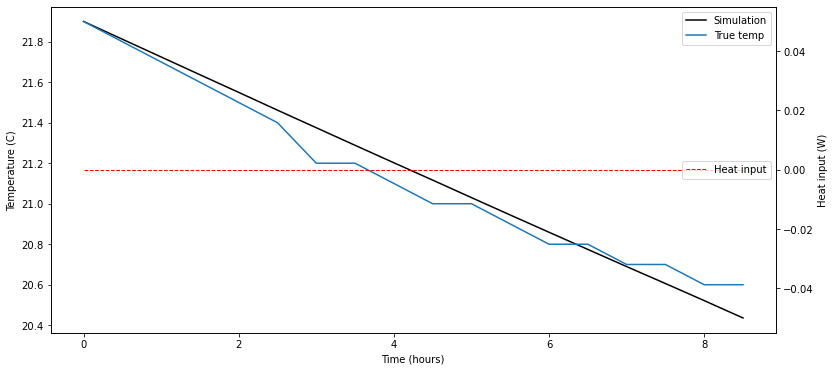

In [17]:

result = minimize(loss_single_seg_fixed_T, x0=initial_params, tol=tolerance, args=('mse', times, T0, Ts_true, T_out, Q_in), bounds=bounds)
k_est, c_est = result['x']
print(results_str.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
sys_fit = model_ND('Fitted', k_est, c_est, T0, T_out, Q_in)
# Run simulation.
Ts = sys_fit.run(times=times).flatten()

fig, ax = sys_fit.plot()
# sys_guess.plot(figax=figax, ls='-.');
ax.plot(times/3600, Ts_true, label='True temp')
# ax.plot(times/3600, T_out, label='Outside')
ax.legend();

Room 1N______________________________________
	Initial			Estimated
k1:	1.80000			3.25716
c1:	500,000.00		500,000.00
_____________________________________________
	Initial			Estimated
k1:	1.80000			4.00957
c1:	500,000.00		500,000.00
_____________________________________________
	Initial			Estimated
k1:	1.80000			3.99088
c1:	500,000.00		500,000.00
_____________________________________________
	Initial			Estimated
k1:	1.80000			3.25944
c1:	500,000.00		500,000.00
_____________________________________________
	Initial			Estimated
k1:	1.80000			3.36984
c1:	500,000.00		500,000.00
_____________________________________________
mean RC = 141,054.21


Room 1S______________________________________
	Initial			Estimated
k1:	1.80000			3.25758
c1:	500,000.00		500,000.00
_____________________________________________
	Initial			Estimated
k1:	1.80000			4.01329
c1:	500,000.00		500,000.00
_____________________________________________
	Initial			Estimated
k1:	1.80000			3.33786
c1:	500,000.00		500,000.00
___

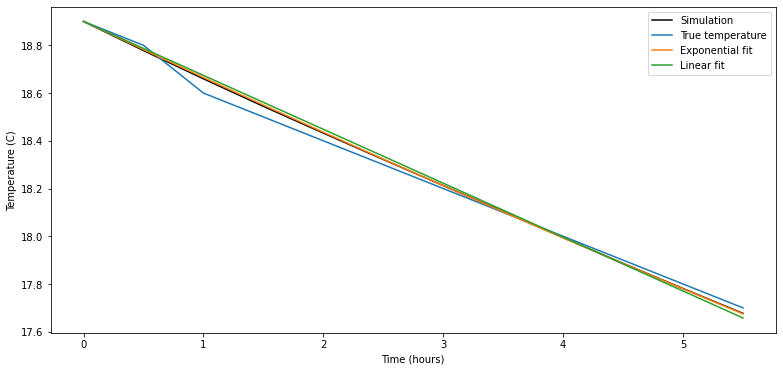

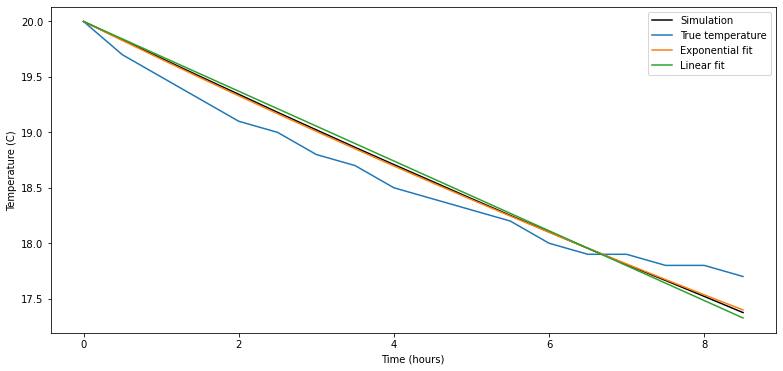

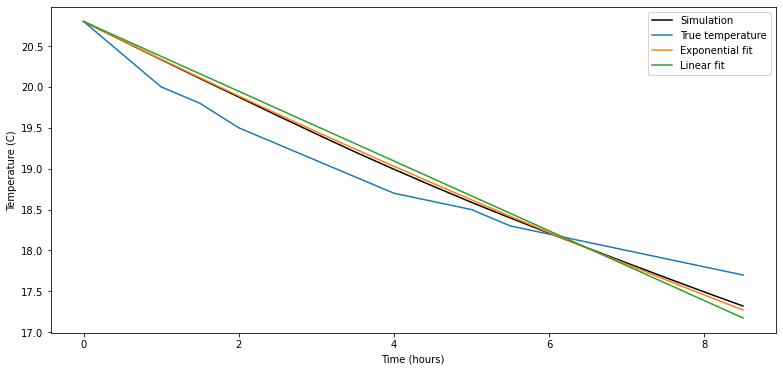

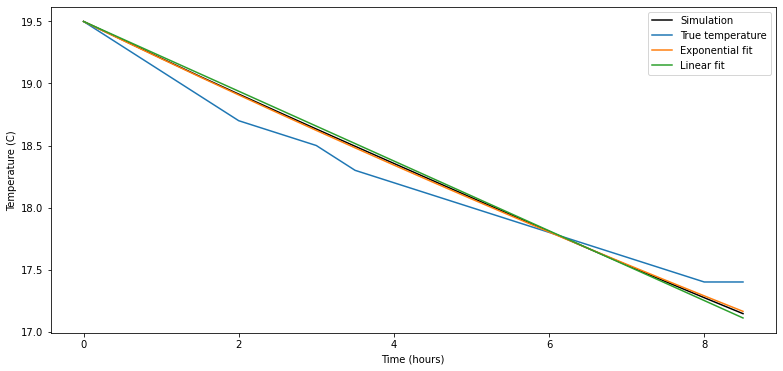

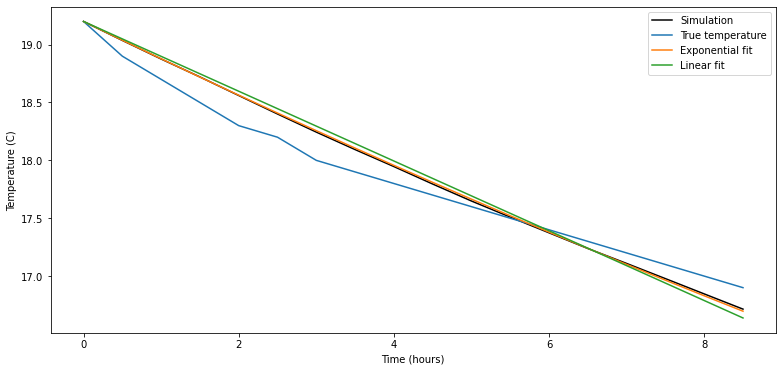

In [36]:
def model_exp(t, tau, T0, t0, T_out):
    return T_out + (T0 - T_out) * np.exp(-(t-t0)/tau)

def model_lin(t, m, T0, t0, T_out):
    return m*(t-t0) + T0

from scipy.optimize import curve_fit

# indicies where gas = 0
mean_RCs = []
mean_fit_exp = []
mean_fit_lin = []
rooms = [str(level) + orientation for level in range(1,5) for orientation in ['N','S']]
for room in rooms:
    print('Room {}'.format(room)+'_'*38)
    results = []
    fit_exp = []
    fit_lin = []
    for lower, upper in indicies:
        times, Ts_true, Q_in, T_out = df[['timestamp',room,'gas','outside']].values[lower:upper].T
        times = (times-times[0])
        T0 = Ts_true[0]

        result = minimize(loss_single_seg_fixed_T, x0=initial_params, tol=tolerance, args=('mse', times, T0, Ts_true, T_out, Q_in), bounds=bounds)
        k_est, c_est = result['x']
        results.append(result['x'])
        print(results_str.format(*np.ravel([initial_params,result['x']],'F')))
        print('_'*45)

        # Initialise class with system parameters
        sys_fit = model_ND('Fitted', k_est, c_est, T0, T_out, Q_in)
        # Run simulation.
        Ts = sys_fit.run(times=times).flatten()
        
        # Model fitting (exp and lin)
        args = (T0, times[0], np.mean(T_out))
        popt_exp, pcov_exp = curve_fit(lambda t, tau: model_exp(t, tau, *args), times, Ts, p0=1e4)
        popt_lin, pcov_lin = curve_fit(lambda t, m:   model_lin(t, m,   *args), times, Ts, p0=-1e-4)

        fit_exp.append(popt_exp)
        fit_lin.append(popt_lin)
        
        # Plotting 
        if room == '1N':
            fig, ax = sys_fit.plot(show_heating=False)
            ax.plot(times/3600, Ts_true, label='True temperature')
            ax.plot(times/3600, model_exp(times, popt_exp[0], *args), label='Exponential fit')
            ax.plot(times/3600, model_lin(times, popt_lin[0], *args), label='Linear fit')        
            # sys_guess.plot(figax=figax, ls='-.');
    #         ax.plot(times/3600, T_out, label='Outside')
            ax.legend();
        
    results = np.array(results)
    # calculating RC from 5 separate intervals where the gas is off
    mean_RC = (results[:,1] / results[:,0]).mean()
    
    mean_RCs.append(mean_RC)
    mean_fit_exp.append(np.array(fit_exp).mean())
    mean_fit_lin.append(np.array(fit_lin).mean())
    print('mean RC = {:,.2f}'.format(mean_RC)) 
    print('='*45+'\n\n')
    

In [19]:
sim_hl = pd.Series(data={room:mean for room, mean in zip(rooms,mean_RCs)}) * np.log(2) / 3600
exp_hl = pd.Series(data={room:mean for room, mean in zip(rooms,mean_fit_exp)}) * np.log(2) / 3600
lin_hl = -0.5*20 / pd.Series(data={room:mean for room, mean in zip(rooms,mean_fit_lin)}) / 3600

The half life, $t_{1/2}$, is given by:
$$ t_{1/2} = \ln(2) RC $$

For our linear fit, we estimate a half life using 20Cs starting temp

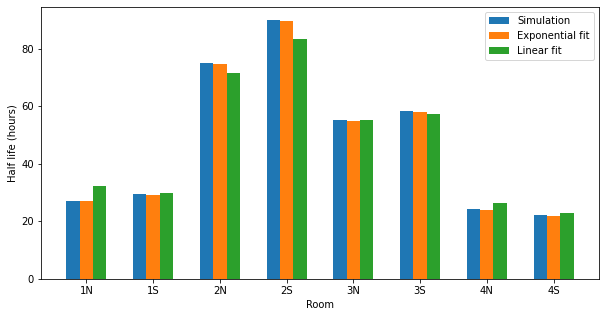

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
labels = ['Simulation', 'Exponential fit', 'Linear fit']
ind = np.arange(len(sim_hl))
width = 0.2
for i, series in enumerate([sim_hl, exp_hl, lin_hl]):
    ax.bar(x=ind + width*(i-1), height=series.values, width=width, label=labels[i])

ax.set(xlabel='Room', ylabel='Half life (hours)', xticks=ind, xticklabels=series.index);
ax.legend()

We see that the top and bottom floors have the shortest half life. This is what we would expect if the outside of the building is cold and the building is losing heat to the ground below and air above. The middle floors (level 2 and 3) are best shielded from the surroundings and therefore have the longest half life, ie retain heat for longer.